In [152]:
#open .mat files?
import h5py
import numpy as np
import matplotlib.pyplot as plt

with h5py.File("Segmentation.mat", "r") as f:
    print("The keys are:", list(f.keys()))
    image = np.array(f["im_segmentation"])
    image = np.transpose(image, (2,1,0))
    res = f["m_per_px"][0][0]*1e6
    print(res)
    cells = np.array(f["masks"]["im_myocytes"])
    cells = np.transpose(cells, (2,1,0))
    print(cells.shape)
    sheetlets = np.array(f["masks"]["im_sheetlets"])
    sheetlets = np.transpose(sheetlets, (2,1,0))
    print(sheetlets.shape)
    
def convert_to_binary(image):
    binary_image = np.zeros(image.shape[:2])
    gray_image = np.mean(image, axis=2)
    binary_image[gray_image > 0] = 1
    return binary_image

binary_cells = convert_to_binary(cells)
binary_sheetlets = convert_to_binary(sheetlets)

The keys are: ['#refs#', 'im_segmentation', 'm_per_px', 'masks', 'sheetlets']
0.057
(6872, 8680, 3)
(6872, 8680, 3)


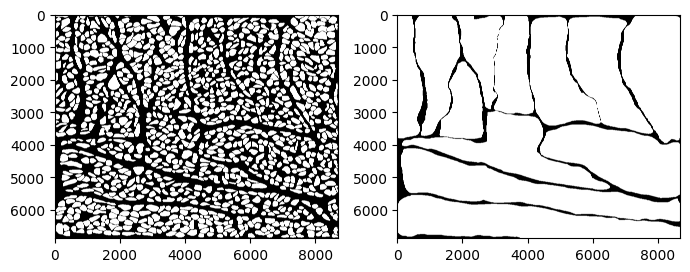

In [80]:
fig, axes = plt.subplots(1,2,figsize=(7,5))
axes[0].imshow(binary_cells, origin="upper",vmin=0, vmax=1,cmap="gray")
axes[1].imshow(binary_sheetlets, origin="upper",vmin=0, vmax=1,cmap="gray")
plt.tight_layout()
plt.show()

In [196]:
from skimage.transform import resize

def resize_image(image, original_size, new_size, res):
    resized_image = resize(image, (new_size,new_size), anti_aliasing=True)
    resized_image = resized_image > 0.5
    new_res = res * (original_size/new_size)
    return resized_image, new_res

def generate_balanced_patches(sheetlet_image,cell_image, patch_size):
    range_x, range_y = sheetlet_image.shape[:2]
    count = 0
    balanced_patches = []
    sheetlet_patches = []
    while count < 1000:
        x = np.random.randint(0, range_x - patch_size)
        y = np.random.randint(0, range_y - patch_size)
        patch = sheetlet_image[x:x+patch_size, y:y+patch_size]
        cell_patch = cell_image[x:x+patch_size, y:y+patch_size]
        sheetlet_to_background_ratio = np.sum(patch) / (patch_size*patch_size)
        if sheetlet_to_background_ratio > 0.3 and sheetlet_to_background_ratio < 0.85:
            resized_patch, _ = resize_image(patch, patch_size, 512, res)
            resized_cell_patch, resized_res = resize_image(cell_patch, patch_size, 512, res)
            balanced_patches.append((resized_patch,resized_cell_patch))
        else:
            resized_patch, _ = resize_image(patch, patch_size, 512, res)
            resized_cell_patch, resized_res = resize_image(cell_patch, patch_size, 512, res)
            sheetlet_patches.append((resized_patch,resized_cell_patch))
        count += 1
    return balanced_patches, sheetlet_patches, resized_res


balanced_patches, sheetlet_patches, new_res = generate_balanced_patches(binary_sheetlets, binary_cells, 800)
print(len(balanced_patches))
print(len(sheetlet_patches))


125
875


Clean cut-offs

In [197]:
from skimage.measure import label, regionprops

def clean_cells_cutoff(cell_image,area_threshold=25):
    labeled_image = label(cell_image)
    props = regionprops(labeled_image)
    area = [prop.area*new_res**2 for prop in props]
    for prop in props:
        if prop.area*new_res**2 < area_threshold:
            cell_image[labeled_image == prop.label] = 0
    return cell_image

def apply_clean_cells_cutoff(patches):
    for i in range(len(patches)):
        cell_image = patches[i][1]
        cell_image = clean_cells_cutoff(cell_image)
        patches[i] = (patches[i][0], cell_image)
    return patches

apply_clean_cells_cutoff(balanced_patches)
apply_clean_cells_cutoff(sheetlet_patches)

[(array([[False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]]),
  array([[False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]])),
 (array([[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  

Text(0.5, 0.98, 'Sheetlet ratio > 0.85')

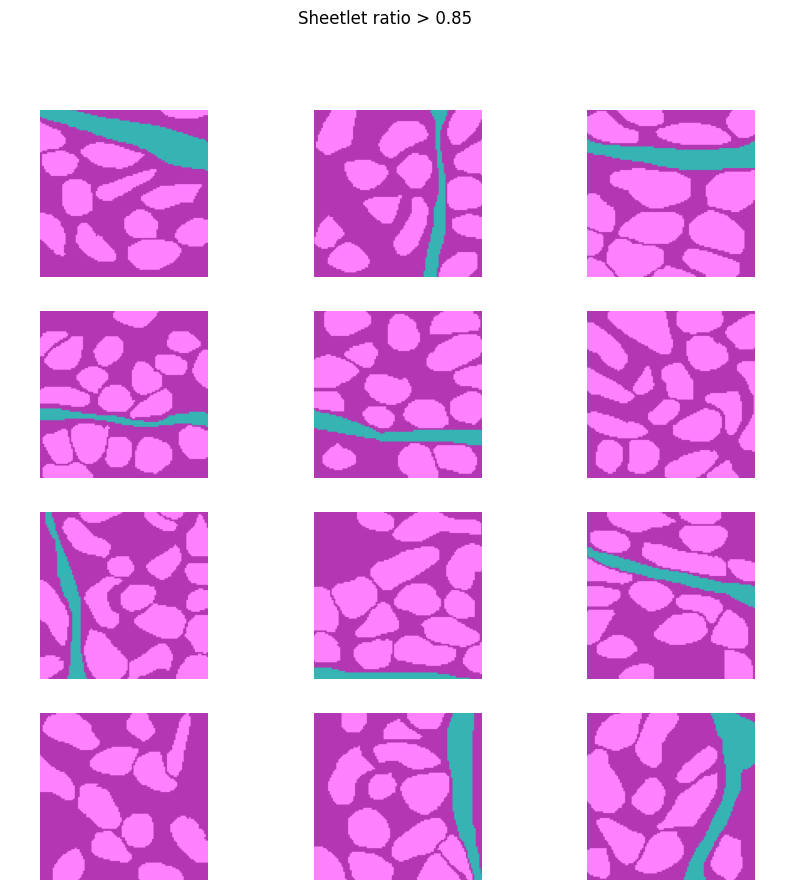

In [198]:
fig, axes = plt.subplots(4,3,figsize=(10,10))
axes = axes.flatten()
count = 0
for i, ax in enumerate(axes):
    ax.imshow(sheetlet_patches[count][0], origin="upper", vmin=0, vmax=1, cmap="cool",alpha=0.7)
    ax.imshow(sheetlet_patches[count][1], origin="upper", vmin=0, vmax=1, cmap="gray",alpha=0.3)
    count += 1
    ax.axis("equal")
    ax.set_axis_off()
plt.suptitle("Sheetlet ratio > 0.85")

Text(0.5, 0.98, 'Balanced patches')

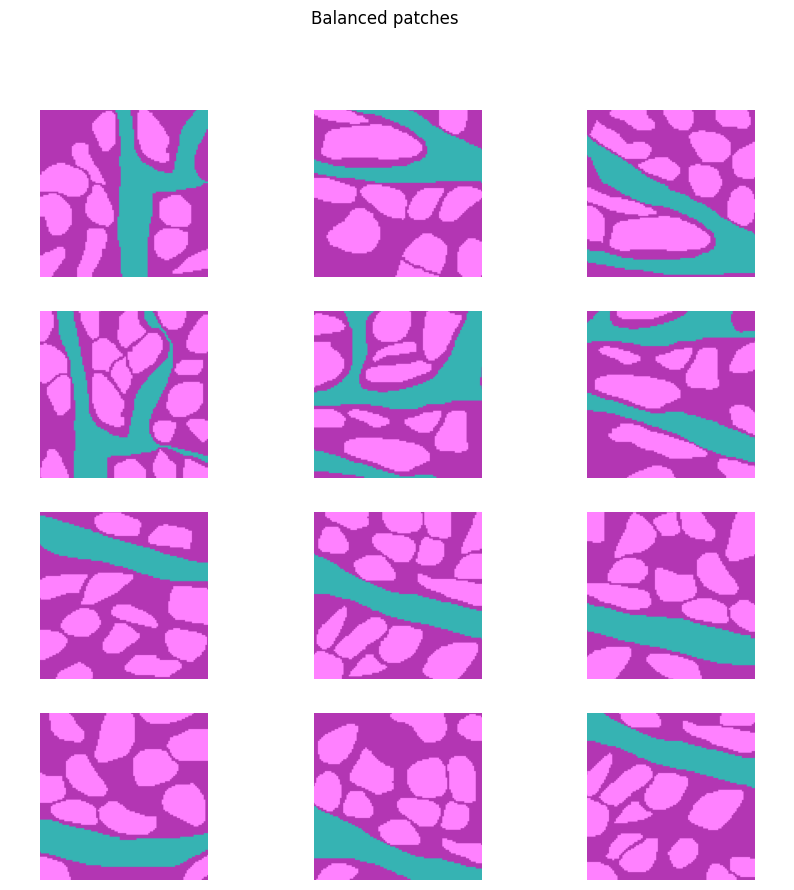

In [199]:
fig, axes = plt.subplots(4,3,figsize=(10,10))
axes = axes.flatten()
count = 0
for i, ax in enumerate(axes):
    ax.imshow(balanced_patches[count][0], origin="upper", vmin=0, vmax=1, cmap="cool",alpha=0.7)
    ax.imshow(balanced_patches[count][1], origin="upper", vmin=0, vmax=1, cmap="gray",alpha=0.3)
    count += 1
    ax.axis("equal")
    ax.set_axis_off()

plt.suptitle("Balanced patches")

In [202]:
#combine balanced patches and sheetlet patches
balanced_patches = np.array(balanced_patches)
sheetlet_patches = np.array(sheetlet_patches)
combined_patches = np.concatenate((balanced_patches, sheetlet_patches), axis=0)
print(combined_patches.shape)
np.save("combined_patches.npy", combined_patches, allow_pickle=True)

(1000, 2, 512, 512)
